<a href="https://colab.research.google.com/github/VIR-WiDS-Team-Dendrites/WiDS_2025/blob/main/71_WiDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Go to this website for steo by step instructions on how to download data: https://www.kaggle.com/discussions/general/74235


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir /root/.config/kaggle

In [ ]:
!ls -a /root/


.   .bashrc  .config   .julia	 .keras		.local	.profile    .wget-hsts
..  .cache   .ipython  .jupyter  .launchpadlib	.npm	.tmux.conf


In [ ]:
!file /root/.config/kaggle


/root/.config/kaggle: directory


Importing and extracting dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mv kaggle.json /root/.config/kaggle/


In [ ]:
 ! chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c widsdatathon2025

 94% 232M/246M [00:01<00:00, 179MB/s]
100% 246M/246M [00:01<00:00, 149MB/s]


In [ ]:
DATA_DIR = "./dataset"

In [ ]:
!mkdir dataset

In [ ]:
!mv ./widsdatathon2025.zip ./dataset

In [ ]:
with zipfile.ZipFile("./dataset/widsdatathon2025.zip", "r") as zip_ref:
    zip_ref.extractall(DATA_DIR)

Looking at Data

In [ ]:
df_cat = pd.read_excel(os.path.join(DATA_DIR, "TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx"))
df_FCM = pd.read_csv(os.path.join(DATA_DIR, "TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"))
df_QTV = pd.read_excel(os.path.join(DATA_DIR, "TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"))
df_TS = pd.read_excel(os.path.join(DATA_DIR, "TRAIN/TRAINING_SOLUTIONS.xlsx"))

In [ ]:
# changing null values to float value '3.0' since this is unknown
df_cat.fillna({'PreInt_Demos_Fam_Child_Ethnicity': 3.0}, inplace=True)

In [ ]:
# df_cat = train categorical metadata
# df_FCM = functional connectome matrices
# df_QTV = quantitative meta data
# df_TS = training solutions

In [ ]:
sns.countplot(x='Barratt_Barratt_P1_Edu', data=df_cat[['Barratt_Barratt_P1_Edu']])
plt.title("Barratt_Barratt_P1_Edu")
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_QTV['MRI_Track_Age_at_Scan'].isnull().sum()

0

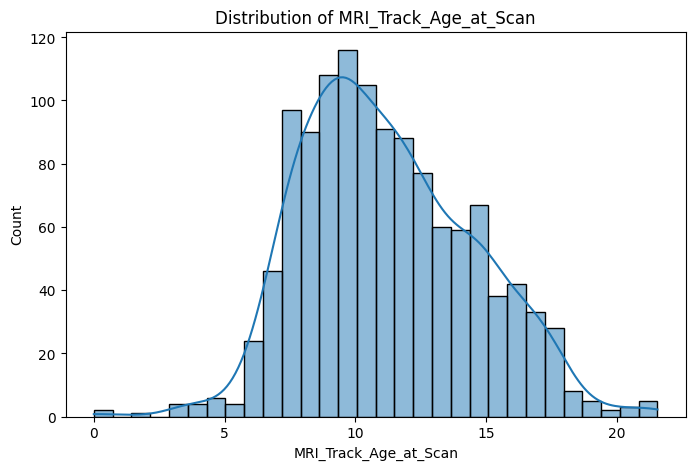

In [ ]:
feature = 'MRI_Track_Age_at_Scan'

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_QTV[feature], kde=True, bins=30)  # KDE adds a smoothed curve
plt.title(f'Distribution of {feature}')
plt.show()

In [ ]:
mean_age = df_QTV['MRI_Track_Age_at_Scan'].mean()
std_age = df_QTV['MRI_Track_Age_at_Scan'].std()

# Fill NaNs with random samples from a normal distribution
num_missing = df_QTV['MRI_Track_Age_at_Scan'].isnull().sum()
df_QTV.loc[df_QTV['MRI_Track_Age_at_Scan'].isnull(), 'MRI_Track_Age_at_Scan'] = np.random.normal(mean_age, std_age, num_missing)


In [ ]:
participant_ids = df_FCM['participant_id']  # Store IDs separately

## Merging Datasets into one by participant ID

In [ ]:
df_FCM['participant_id'] = participant_ids

training_cat_FCM_df = pd.merge(df_cat, df_FCM, on='participant_id')
training_df = pd.merge(training_cat_FCM_df, df_QTV, on='participant_id')
final_df = pd.merge(training_df, df_TS, on='participant_id')
final_df = final_df.drop(columns=['participant_id'])

In [ ]:
final_df.head(10)

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,0throw_1thcolumn,...,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan,ADHD_Outcome,Sex_F
0,2016,1,0.0,0,1,21,45,21,45,-0.039820,...,1,5,0,5,1,0,10,12.805476,1,1
1,2019,3,1.0,2,3,15,15,0,0,0.114480,...,6,8,7,8,10,4,5,8.573381,1,0
2,2016,1,1.0,8,1,18,40,0,0,0.226402,...,2,8,5,7,6,4,9,8.239904,1,0
3,2018,3,0.0,8,3,15,30,18,0,0.060679,...,4,16,9,10,8,4,6,17.156184,1,1
4,2019,3,0.0,1,3,15,20,0,0,0.056123,...,4,11,4,10,7,3,9,8.940679,1,1
5,2018,1,0.0,8,3,21,0,18,45,0.063914,...,0,12,9,8,5,5,3,8.417876,1,0
6,2018,3,0.0,0,3,18,25,15,35,0.070287,...,1,5,1,5,4,3,10,16.768195,1,0
7,2019,1,0.0,0,2,21,40,18,40,0.073525,...,3,11,6,8,5,2,6,11.221309,1,0
8,2015,1,0.0,0,1,21,40,18,35,0.094771,...,6,14,2,9,9,3,10,8.570841,1,1
9,2019,3,0.0,3,3,15,25,15,10,0.087224,...,4,15,6,10,10,6,5,15.410221,1,0


In [ ]:
final_df.isnull().sum().sum()

0

In [ ]:
feature_labels = final_df.iloc[:, :-2]
adhd_label = final_df['ADHD_Outcome']
sex_label = final_df['Sex_F']

In [ ]:
feature_tensors = torch.tensor(feature_labels.values, dtype=torch.float32)
adhd_tensors = torch.tensor(adhd_label, dtype=torch.float32).unsqueeze(1)  # Shape: [batch_size, 1]
sex_tensors = torch.tensor(sex_label, dtype=torch.float32).unsqueeze(1)    # Shape: [batch_size, 1]

In [ ]:
import torch
import torch.nn as nn

class MultiOutputModel(nn.Module):
    def __init__(self, input_dim):
        super(MultiOutputModel, self).__init__()

        # Shared feature extraction layer
        self.shared_fc = nn.Linear(input_dim, 128)
        self.shared_relu = nn.ReLU()

        # ADHD-specific branch
        self.adhd_fc1 = nn.Linear(128, 64)
        self.adhd_relu = nn.ReLU()
        self.adhd_fc2 = nn.Linear(64, 1)

        # Sex-specific branch
        self.sex_fc1 = nn.Linear(128, 64)
        self.sex_relu = nn.ReLU()
        self.sex_fc2 = nn.Linear(64, 1)

        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Shared feature extraction
        x = self.shared_fc(x)
        x = self.shared_relu(x)

        # ADHD branch
        adhd_x = self.adhd_fc1(x)
        adhd_x = self.adhd_relu(adhd_x)
        adhd_output = self.sigmoid(self.adhd_fc2(adhd_x))

        # Sex branch
        sex_x = self.sex_fc1(x)
        sex_x = self.sex_relu(sex_x)
        sex_output = self.sigmoid(self.sex_fc2(sex_x))

        return adhd_output, sex_output

In [ ]:
# Instantiate model
input_dim = feature_tensors.shape[1]  # Number of features in fMRI vector
model = MultiOutputModel(input_dim)

# Defining loss functions for binary classification (Binary Cross-Entropy Loss)
loss_fn = nn.BCELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training Loop


In [ ]:
# Combine inputs and targets into a dataset
dataset = torch.utils.data.TensorDataset(feature_tensors, adhd_tensors, sex_tensors)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0

    for fmri_batch, adhd_batch, sex_batch in dataloader:
        optimizer.zero_grad()

        # Forward pass through the model
        adhd_pred, sex_pred = model(fmri_batch)

        # Compute losses for both outputs
        loss_adhd = loss_fn(adhd_pred, adhd_batch)
        loss_sex = loss_fn(sex_pred, sex_batch)

        # Combine losses (you can use weights if needed)
        loss = loss_adhd + loss_sex

        # Backpropagation and optimization step
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 49.6406
Epoch 2, Loss: 45.5561
Epoch 3, Loss: 39.2715
Epoch 4, Loss: 32.2625
Epoch 5, Loss: 22.7127
Epoch 6, Loss: 13.0009
Epoch 7, Loss: 6.5713
Epoch 8, Loss: 2.6188
Epoch 9, Loss: 1.4278
Epoch 10, Loss: 0.8163
Epoch 11, Loss: 0.4421
Epoch 12, Loss: 0.2613
Epoch 13, Loss: 0.1674
Epoch 14, Loss: 0.1193
Epoch 15, Loss: 0.0897
Epoch 16, Loss: 0.0703
Epoch 17, Loss: 0.0562
Epoch 18, Loss: 0.0462
Epoch 19, Loss: 0.0386
Epoch 20, Loss: 0.0329
Epoch 21, Loss: 0.0284
Epoch 22, Loss: 0.0244
Epoch 23, Loss: 0.0212
Epoch 24, Loss: 0.0189
Epoch 25, Loss: 0.0166
Epoch 26, Loss: 0.0149
Epoch 27, Loss: 0.0134
Epoch 28, Loss: 0.0121
Epoch 29, Loss: 0.0111
Epoch 30, Loss: 0.0101
Epoch 31, Loss: 0.0092
Epoch 32, Loss: 0.0084
Epoch 33, Loss: 0.0078
Epoch 34, Loss: 0.0073
Epoch 35, Loss: 0.0067
Epoch 36, Loss: 0.0062
Epoch 37, Loss: 0.0058
Epoch 38, Loss: 0.0054
Epoch 39, Loss: 0.0050
Epoch 40, Loss: 0.0047
Epoch 41, Loss: 0.0044
Epoch 42, Loss: 0.0042
Epoch 43, Loss: 0.0039
Epoch 44, Loss

In [ ]:
model.eval()

with torch.no_grad():
    test_adhd_pred, test_sex_pred = model(feature_tensors)

    # Threshold predictions at 0.5 to get binary labels
    adhd_pred_labels = (test_adhd_pred > 0.5).float()
    sex_pred_labels = (test_sex_pred > 0.5).float()

    # Calculate accuracy for ADHD prediction
    adhd_accuracy = (adhd_pred_labels == adhd_tensors).float().mean().item()

    # Calculate accuracy for Sex prediction
    sex_accuracy = (sex_pred_labels == sex_tensors).float().mean().item()

print(f"ADHD Prediction Accuracy: {adhd_accuracy:.4f}")
print(f"Sex Prediction Accuracy: {sex_accuracy:.4f}")


ADHD Prediction Accuracy: 1.0000
Sex Prediction Accuracy: 1.0000


# Testing model accuracy


In [ ]:
test_cat = pd.read_excel(os.path.join(DATA_DIR, "TEST/TEST_CATEGORICAL.xlsx"))
test_FCM = pd.read_csv(os.path.join(DATA_DIR, "TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"))
test_QTV = pd.read_excel(os.path.join(DATA_DIR, "TEST/TEST_QUANTITATIVE_METADATA.xlsx"))

In [ ]:
QTV_PAR_ID = test_QTV['participant_id']
test_QTV = test_QTV.drop(columns=['participant_id'])

In [ ]:
columns = test_QTV.columns

In [ ]:
# Fill Age at time of MRI scan with median (since it's skewed)
test_QTV['MRI_Track_Age_at_Scan'].fillna(test_QTV["MRI_Track_Age_at_Scan"].median(), inplace=True)

# Fill all other numerical missing values with their respective column means
for col in columns:
    test_QTV[col].fillna(test_QTV[col].mean(), inplace=True)

test_QTV.fillna(test_QTV.median(), inplace=True)

# Confirm that no missing values remain
print(test_QTV.isnull().sum().sum())


0


<ipython-input-90-a090875b2e2a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_QTV['MRI_Track_Age_at_Scan'].fillna(test_QTV["MRI_Track_Age_at_Scan"].median(), inplace=True)
<ipython-input-90-a090875b2e2a>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doi

In [ ]:
test_QTV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   EHQ_EHQ_Total               304 non-null    float64
 1   ColorVision_CV_Score        304 non-null    float64
 2   APQ_P_APQ_P_CP              304 non-null    float64
 3   APQ_P_APQ_P_ID              304 non-null    float64
 4   APQ_P_APQ_P_INV             304 non-null    float64
 5   APQ_P_APQ_P_OPD             304 non-null    float64
 6   APQ_P_APQ_P_PM              304 non-null    float64
 7   APQ_P_APQ_P_PP              304 non-null    float64
 8   SDQ_SDQ_Conduct_Problems    304 non-null    float64
 9   SDQ_SDQ_Difficulties_Total  304 non-null    float64
 10  SDQ_SDQ_Emotional_Problems  304 non-null    float64
 11  SDQ_SDQ_Externalizing       304 non-null    float64
 12  SDQ_SDQ_Generating_Impact   304 non-null    float64
 13  SDQ_SDQ_Hyperactivity       304 non

In [ ]:
test_cat['PreInt_Demos_Fam_Child_Ethnicity'].fillna(3.0, inplace=True)
test_cat['PreInt_Demos_Fam_Child_Race'].fillna(10.0, inplace=True)
test_cat['Barratt_Barratt_P1_Edu'].fillna(0.0, inplace=True)
test_cat['Barratt_Barratt_P2_Edu'].fillna(0.0, inplace=True)
test_cat['Barratt_Barratt_P1_Occ'].fillna(50.0, inplace=True)
test_cat['Barratt_Barratt_P2_Occ'].fillna(50.0, inplace=True)

<ipython-input-91-3c0a2f002f28>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_cat['PreInt_Demos_Fam_Child_Ethnicity'].fillna(3.0, inplace=True)
<ipython-input-91-3c0a2f002f28>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [ ]:
test_QTV['participant_id'] = QTV_PAR_ID
# Merge datasets on participant_id
test_cat_FCM_df = pd.merge(test_cat, test_FCM, on='participant_id')
test_df = pd.merge(test_cat_FCM_df, test_QTV, on='participant_id')

# Extract participant IDs before modifying them
test_participant_ids = test_df['participant_id'].tolist()  # Keep original IDs for final predictions

# Drop participant_id from features since it's not a useful feature
test_features = test_df.drop(columns=['participant_id'])

test_features_tensors = torch.tensor(test_features.values, dtype=torch.float32)

# Ensure tensor shape matches model input
print("Test feature tensor shape:", test_features_tensors.shape)
print("Model input shape:", feature_tensors.shape)


Test feature tensor shape: torch.Size([304, 19927])
Model input shape: torch.Size([1213, 19927])


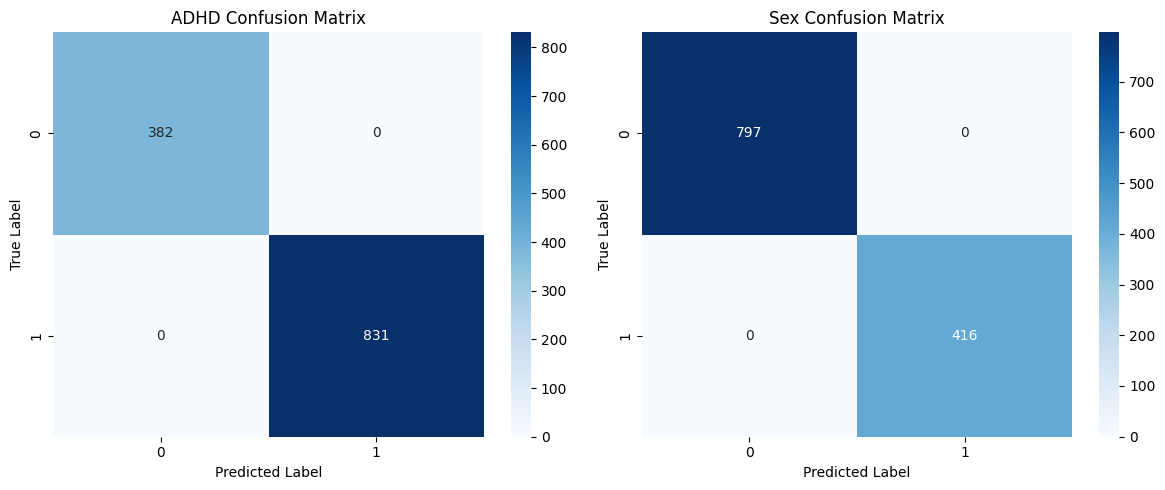

ADHD Classification Report:
              precision    recall  f1-score   support

     No ADHD       1.00      1.00      1.00       382
        ADHD       1.00      1.00      1.00       831

    accuracy                           1.00      1213
   macro avg       1.00      1.00      1.00      1213
weighted avg       1.00      1.00      1.00      1213


Sex Classification Report:
              precision    recall  f1-score   support

      Female       1.00      1.00      1.00       797
        Male       1.00      1.00      1.00       416

    accuracy                           1.00      1213
   macro avg       1.00      1.00      1.00      1213
weighted avg       1.00      1.00      1.00      1213



In [ ]:
model.eval()

with torch.no_grad():
    # Making predictions
    adhd_pred, sex_pred = model(feature_tensors)

    # Convert predictions to binary (0 or 1) using 0.5 as threshold
    adhd_pred_binary = (adhd_pred > 0.5).float()
    sex_pred_binary = (sex_pred > 0.5).float()

# Convert tensors to numpy arrays
adhd_true = adhd_tensors.numpy()
sex_true = sex_tensors.numpy()
adhd_pred = adhd_pred_binary.numpy()
sex_pred = sex_pred_binary.numpy()

adhd_cm = confusion_matrix(adhd_true, adhd_pred)
sex_cm = confusion_matrix(sex_true, sex_pred)

# Plot confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(adhd_cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('ADHD Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

sns.heatmap(sex_cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Sex Confusion Matrix')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report

print("ADHD Classification Report:")
print(classification_report(adhd_true, adhd_pred, target_names=['No ADHD', 'ADHD']))

print("\nSex Classification Report:")
print(classification_report(sex_true, sex_pred, target_names=['Female', 'Male']))


In [ ]:
model.eval()

# Make predictions on test dataset (no ADHD or Sex labels available)
with torch.no_grad():
    test_adhd_pred, test_sex_pred = model(test_features_tensors)

    # Convert probabilities to binary predictions
    test_adhd_labels = (test_adhd_pred > 0.5).float()
    test_sex_labels = (test_sex_pred > 0.5).float()

test_results = pd.DataFrame({
    'participant_id': test_participant_ids,  # Ensure this matches the test set
    'predicted_adhd': test_adhd_labels.squeeze().tolist(),
    'predicted_sex': test_sex_labels.squeeze().tolist()
})

# Save predictions to CSV
test_results.to_csv('submission.csv', index=False)

print(test_results.head())


  participant_id  predicted_adhd  predicted_sex
0   Cfwaf5FX7jWK             1.0            1.0
1   vhGrzmvA3Hjq             1.0            1.0
2   ULliyEXjy4OV             1.0            1.0
3   LZfeAb1xMtql             0.0            1.0
4   EnFOUv0YK1RG             1.0            0.0
